In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

## Initializing a project

In [13]:
from os import path
import mlrun

# Set the base project name
project_name_base = 'deepfake-shield'
# Initialize the MLRun environment and save the project name and artifacts path
project_name, artifact_path = mlrun.set_environment(project=project_name_base,
                                                    user_project=True, api_path = './api_dir', artifact_path = './artifact_dir')
                                                    
# Display the current project name and artifacts path
print(f'Project name: {project_name}')
print(f'Artifacts path: {artifact_path}')

Project name: deepfake-shield-mayukh
Artifacts path: /media/mayukh/Data/storage/repositories/repos/deep-shield-temp/notebooks/artifact_dir


## Initialize training code with `mlrun`

In [87]:
# mlrun: start-code

In [88]:
import os
import cv2
import numpy as np
import pandas as pd
import sklearn.metrics
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
from mlrun.datastore import DataItem 
from mlrun.artifacts import PlotArtifact

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import gc 
import random
from torch.utils.data import Dataset, DataLoader
from pytorchcv.model_provider import get_model as ptcv_get_model

In [89]:

class ImageDataset(Dataset):
    def __init__(self, x, y, training=True, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.x[idx]
        
        img_numpy = read_img(img_path)
#         print(img_numpy.max(), img_numpy.min())

        if self.transform is not None:
            res = self.transform(image=img_numpy)
            img_numpy = res['image']
            
        img_tensor = torch.tensor(img_numpy).permute(-1,0,1)
        

        labels = self.y[idx]
        return {
            'image': img_tensor,
            'label': labels
        }

In [90]:
class Head(torch.nn.Module):
    def __init__(self, in_f, out_f):
        super(Head, self).__init__()

        self.f = nn.Flatten()
        self.l = nn.Linear(in_f, 512)
        self.d = nn.Dropout(0.75)
        self.o = nn.Linear(512, out_f)
        self.b1 = nn.BatchNorm1d(in_f)
        self.b2 = nn.BatchNorm1d(512)
        self.r = nn.ReLU()

    def forward(self, x):
#         print(x.shape)
        x = x.reshape(x.size(0), -1)
        x = self.b1(x)
        x = self.d(x)

        x = self.l(x)
        x = self.r(x)
        x = self.b2(x)
        x = self.d(x)

        out = self.o(x)
        return out
    
class FCN(torch.nn.Module):
    def __init__(self, base, in_f):
        super(FCN, self).__init__()
        self.base = base
        self.h1 = Head(in_f, 1)
  
    def forward(self, x):
        x = self.base(x)
        return self.h1(x)


In [91]:
def get_model():
    model = ptcv_get_model("efficientnet_b4")
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    model = FCN(model, 1792)
    model = model.cuda()
    
    return model

In [92]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

def get_random_sampling(paths, y, val_paths, val_y, num_train_samples = None, num_val_samples = None):
    real=[]
    fake=[]
    for m,n in zip(paths,y):
        if n==0:
            real.append(m)
        else:
            fake.append(m)
  # fake=random.sample(fake,len(real))
    paths,y=[],[]
    for x in real:
        paths.append(x)
        y.append(0)
    for x in fake:
        paths.append(x)
        y.append(1)

    real=[]
    fake=[]
    
    for m,n in zip(val_paths,val_y):
        if n==0:
            real.append(m)
        else:
            fake.append(m)
    
    
    val_paths,val_y=[],[]
    for x in real:
        val_paths.append(x)
        val_y.append(0)
    for x in fake:
        val_paths.append(x)
        val_y.append(1)

    X=[]
    for img in tqdm(paths):
        X.append(img)
    val_X=[]
    for img in tqdm(val_paths):
        val_X.append(img)

  # Balance with ffhq dataset
    ffhq = os.listdir('training_data/ffhq/thumbnails128x128')
    X_ = []
    for file in tqdm(ffhq):
        path = f'training_data/ffhq/thumbnails128x128/{file}'
        X_.append(path)
    random.shuffle(X_)

    for i in range(64773 - 12130):
        X.append(X_[i])
        y.append(0)
    
    
    del X_[0:64773 - 12130]

    for i in range(6108 - 1258):
        val_X.append(X_[i])
        val_y.append(0)

    X, y = shuffle(X,y)
    val_X, val_y = shuffle(val_X,val_y)
    
    if num_train_samples is not None:
        X, y = X[:num_train_samples], y[:num_train_samples]
        
    if num_val_samples is not None:
        val_X, val_y = X[:num_val_samples], y[:num_val_samples]

    return X, val_X, y, val_y

def train_n_epochs(model, num_epochs , train_loader, val_loader, checkpoint_name = 'model.pth', lr = 0.001, loss = None, context = None):
    
    best_acc = 0.
    accuracies = []
    losses = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        gc.collect()

        model, loss = train_model(model, epoch, optimizer, scheduler, loss = loss, train_loader= train_loader)
        losses.append(loss)
        
        acc = evaluate_model(model, val_loader)
        accuracies.append(acc)
        
        if acc > best_acc:
            best_acc = acc
            print(f'Saving best model: {checkpoint_name}')
            torch.save(model.state_dict(), checkpoint_name)
            
        if context is not None:
            context.logger.info(f'epoch: {epoch+1} current acc: {round(acc, 4)} best acc: {round(best_acc, 4)}')
            
            
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
    
    ax[0].plot(losses)
    ax[0].set_ylabel('Loss', fontsize = 18)
    ax[0].set_xlabel('Epochs', fontsize = 18)
    
    ax[1].plot(accuracies, c = 'g')
    ax[1].set_ylabel('Accuracy', fontsize = 18)
    ax[1].set_xlabel('Epochs', fontsize = 18)
    
    context.log_artifact(PlotArtifact('training logs', body=fig))

    return model

In [93]:

def evaluate_model(model, val_loader):
    model.eval()
    pred = []
    real = []
    with torch.no_grad():
        for batch in val_loader:
        
            img_batch, y_batch = batch['image'].cuda().float(), batch['label'].cuda().float()

            o1 = model(img_batch)
            
            for j in o1:
                pred.append(F.sigmoid(j))
                
            for i in y_batch:
                real.append(i.data.cpu())
    
    pred = [p.data.cpu().numpy() for p in pred]
    pred = [np.round(p) for p in pred]
    pred = np.array(pred)
    acc = sklearn.metrics.recall_score(real, pred, average='macro')

    return acc

def criterion(pred1, targets):
    l1 = F.binary_cross_entropy(F.sigmoid(pred1).squeeze(-1), targets)
    return l1

def train_model(model, epoch, optimizer, scheduler, loss , train_loader):
    model.train()
    total_loss = 0

    t = tqdm(train_loader, disable = True)
    for i, batch in enumerate(train_loader):
        
        img_batch = batch['image']
        img_batch = img_batch.cuda()

        y_batch = batch['label']
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion(out, y_batch)
        

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        loss.backward()
        optimizer.step()
        
    scheduler.step(1.)

    return model, total_loss

In [94]:
from mlrun.mlutils.data import get_sample
import pandas as pd 
import albumentations
from albumentations import (
    ShiftScaleRotate, 
    HorizontalFlip, 
    Normalize, 
    GaussNoise, 
)

def get_training_data(train_dataset: DataItem, val_dataset: DataItem, 
                      label_column = 'labels', df_train_path = 'df_train.csv',
                      df_val_path = 'df_val.csv', ideal_params = None): 
    
    df_train = pd.read_csv(df_train_path)
    df_val = pd.read_csv(df_val_path)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transform = albumentations.Compose([
        ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
        HorizontalFlip(p=0.2),
        GaussNoise(p=.2),
        Normalize(mean = mean, std = std),
        albumentations.augmentations.geometric.resize.Resize(128,128)
    ])
    
    val_transform = albumentations.Compose([
      Normalize(mean = mean, std = std),
      albumentations.augmentations.geometric.resize.Resize(128,128)
    ])

        
    raw, labels, header = get_sample(train_dataset, sample=-1, label=label_column)
    raw_val, labels_val, header = get_sample(val_dataset, sample=-1, label=label_column)    
    
    X, y = raw['paths'].values, labels.values
    val_X, val_y = raw_val['paths'].values, labels_val.values

    X, val_X, Y, val_Y = get_random_sampling(
        df_train['paths'].values, 
        df_train['labels'].values, 
        df_val['paths'].values,
        df_val['labels'].values, 
        num_train_samples= None, # Set this to None if you want to train on the whole dataset
        num_val_samples= None     # Set this to None if you want to train on the whole dataset
    )

    train_dataset = ImageDataset(X, Y, transform=train_transform)
    val_dataset = ImageDataset(val_X, val_Y, transform=val_transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=ideal_params['batch_size'], shuffle=True, num_workers=4)
    val_loader = DataLoader(dataset=val_dataset, batch_size= 10, shuffle=False, num_workers=0)

    return {
        'train_loader': train_loader,
        'val_loader': val_loader
    }



def train_model_auto(context, train_dataset: DataItem, val_dataset: DataItem, 
                     num_epochs, hyperparams, checkpoint_name, df_train_path, df_val_path):
    
    print("started training :)")
    
    data = get_training_data(
        train_dataset= train_dataset,
        val_dataset= val_dataset,
        df_train_path = df_train_path,
        df_val_path = df_val_path,
        ideal_params= hyperparams
    )
    
    model = get_model()
    
    train_n_epochs(
        model = model,
        num_epochs = num_epochs,
        train_loader= data['train_loader'],
        val_loader=  data['val_loader'],
        lr = hyperparams['learning_rate'],
        loss = criterion,
        checkpoint_name = checkpoint_name,
        context = context  ## context passed into fn
    )
    

In [95]:
# mlrun: end-code

In [96]:
train_func = mlrun.code_to_function(
    name='train_model_auto',
    kind='job',
    image='mlrun/mlrun'
)

## Training the model with `mlrun`

In [97]:
train_dataset = f'store://{project_name}/prep_data_deepfake_dataset_train'
val_dataset = f'store://{project_name}/prep_data_deepfake_dataset_val'

In [84]:
results = pd.read_csv('artifact_dir/iteration_results.csv')
best_iter = results[results['output.loss'] == results['output.loss'].min()]

ideal_params = {
    'learning_rate': best_iter['param.learning_rate'].values[0],
    'batch_size': best_iter['param.batch_size'].values[0]
}

In [98]:
ideal_params

{'learning_rate': 0.002508, 'batch_size': 16}

> 2021-07-03 13:17:02,549 [info] starting run train_model_auto uid=a0174e29d33a47d2adf827fe393c5e02 DB=./api_dir
started training :)


100%|██████████| 70000/70000 [00:00<00:00, 3777388.26it/s]


Saving best model: model.pt
> 2021-07-03 13:17:07,229 [info] epoch: 1 current acc: 0.5 best acc: 0.5
> 2021-07-03 13:17:08,558 [info] epoch: 2 current acc: 0.5 best acc: 0.5
> 2021-07-03 13:17:09,903 [info] epoch: 3 current acc: 0.5 best acc: 0.5
Saving best model: model.pt
> 2021-07-03 13:17:11,580 [info] epoch: 4 current acc: 0.5244 best acc: 0.5244
Saving best model: model.pt
> 2021-07-03 13:17:13,270 [info] epoch: 5 current acc: 0.5366 best acc: 0.5366
Saving best model: model.pt
> 2021-07-03 13:17:15,008 [info] epoch: 6 current acc: 0.6463 best acc: 0.6463
Epoch     7: reducing learning rate of group 0 to 1.7556e-03.
Saving best model: model.pt
> 2021-07-03 13:17:16,690 [info] epoch: 7 current acc: 0.7195 best acc: 0.7195
> 2021-07-03 13:17:18,032 [info] epoch: 8 current acc: 0.6707 best acc: 0.7195
Saving best model: model.pt
> 2021-07-03 13:17:19,728 [info] epoch: 9 current acc: 0.7805 best acc: 0.7805
Saving best model: model.pt
> 2021-07-03 13:17:21,410 [info] epoch: 10 curren

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
deepfake-shield-mayukh,...3c5e02,0,Jul 03 07:47:02,completed,train_model_auto,kind=owner=mayukhhost=leopard,train_datasetval_dataset,"num_epochs=15hyperparams={'learning_rate': 0.002508, 'batch_size': 16}checkpoint_name=model.ptdf_train_path=df_train.csvdf_val_path=df_val.csv",,training logs


to track results use .show() or .logs() or in CLI: 
!mlrun get run a0174e29d33a47d2adf827fe393c5e02 --project deepfake-shield-mayukh , !mlrun logs a0174e29d33a47d2adf827fe393c5e02 --project deepfake-shield-mayukh
> 2021-07-03 13:17:29,784 [info] run executed, status=completed


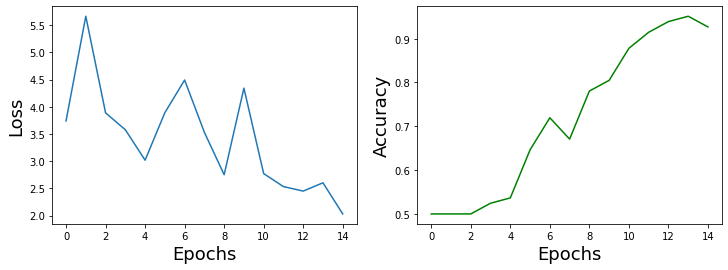

In [99]:
params = {
    'num_epochs':15,  
    'hyperparams': ideal_params,
    'checkpoint_name': 'model.pt',
    'df_train_path': 'df_train.csv',
    'df_val_path': 'df_val.csv'
}

inputs = {
    'train_dataset': train_dataset,
    'val_dataset': val_dataset
    
}

train_run = train_func.run(name='train_model_auto',
                                   handler=train_model_auto,
                                   inputs=inputs,
                                   params = params,
                                   local=True)

In [116]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

val_transform = albumentations.Compose([
      Normalize(mean = mean, std = std),
      albumentations.augmentations.geometric.resize.Resize(128,128)
    ])

df_val = pd.read_csv(params['df_val_path'])
val_X, val_Y = df_val['paths'].values, df_val['labels'].values

val_dataset = ImageDataset(val_X, val_Y, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size= 10, shuffle=False, num_workers=0)

In [119]:
best_model = get_model()
best_model.load_state_dict(torch.load(params['checkpoint_name']))

acc = evaluate_model(model = best_model.cuda(), val_loader = val_loader)
print(f'final accuracy: {round(acc,2)}')

final accuracy: 0.95
